In [6]:
# colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Unet - Chest CT Dataset

## 데이터 전처리

In [302]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

import os
import numpy as np
import pandas as pd
import shutil
import cv2
import matplotlib.pyplot as plt

from IPython import display

### kaggle datasets Download
- 데이터 : Chest CT Segmentation(Chest CT scans together with segmentation masks for lung, heart, and trachea)
- 캐글 데이터 주소: https://www.kaggle.com/datasets/polomarco/chest-ct-segmentation

In [8]:
!pip install kaggle --upgrade

In [9]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seonyong","key":"15cdbf608ae7dcc43e31d8ac3e790795"}'}

In [10]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
!mkdir './ckpt'
!mkdir './chestct'
%cd chestct/

/content/chestct


In [12]:
!kaggle datasets download -d polomarco/chest-ct-segmentation

 99% 1.60G/1.61G [00:21<00:00, 81.8MB/s]
100% 1.61G/1.61G [00:21<00:00, 79.5MB/s]


In [13]:
!unzip -qq '/content/chestct/chest-ct-segmentation.zip'
%cd ..

/content


### 데이터 살펴보기

In [14]:
data_raw = pd.read_csv('/content/chestct/train.csv')
data_raw.head()

,ImageId,MaskId
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg


In [15]:
data_raw.shape

(16708, 2)

In [16]:
def get_id(x):
    return x.split('_')[0]

data_raw['id'] = data_raw.ImageId.apply(lambda x: get_id(x))
data_raw.head()

,ImageId,MaskId,id
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg,ID00007637202177411956430
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg,ID00007637202177411956430
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg,ID00007637202177411956430
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg,ID00007637202177411956430
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg,ID00007637202177411956430


In [17]:
cli_ids = data_raw.id.unique()
len(cli_ids)

112

In [18]:
# 이미지가 303장 차이. -> 실제로 이미지와 마스크 이미지를 불러와서 비교할 필요성 있음.
print(len(os.listdir('/content/chestct/images/images')), len(os.listdir('/content/chestct/masks/masks')))

17011 16708


In [19]:
cli_id = -1
cli_data = data_raw[data_raw.id == cli_ids[cli_id]]
cli_data

,ImageId,MaskId,id
16300,ID00426637202313170790466_0.jpg,ID00426637202313170790466_mask_0.jpg,ID00426637202313170790466
16301,ID00426637202313170790466_1.jpg,ID00426637202313170790466_mask_1.jpg,ID00426637202313170790466
16302,ID00426637202313170790466_2.jpg,ID00426637202313170790466_mask_2.jpg,ID00426637202313170790466
16303,ID00426637202313170790466_3.jpg,ID00426637202313170790466_mask_3.jpg,ID00426637202313170790466
16304,ID00426637202313170790466_4.jpg,ID00426637202313170790466_mask_4.jpg,ID00426637202313170790466
...,...,...,...
16703,ID00426637202313170790466_403.jpg,ID00426637202313170790466_mask_403.jpg,ID00426637202313170790466
16704,ID00426637202313170790466_404.jpg,ID00426637202313170790466_mask_404.jpg,ID00426637202313170790466
16705,ID00426637202313170790466_405.jpg,ID00426637202313170790466_mask_405.jpg,ID00426637202313170790466
16706,ID00426637202313170790466_406.jpg,ID00426637202313170790466_mask_406.jpg,ID00426637202313170790466


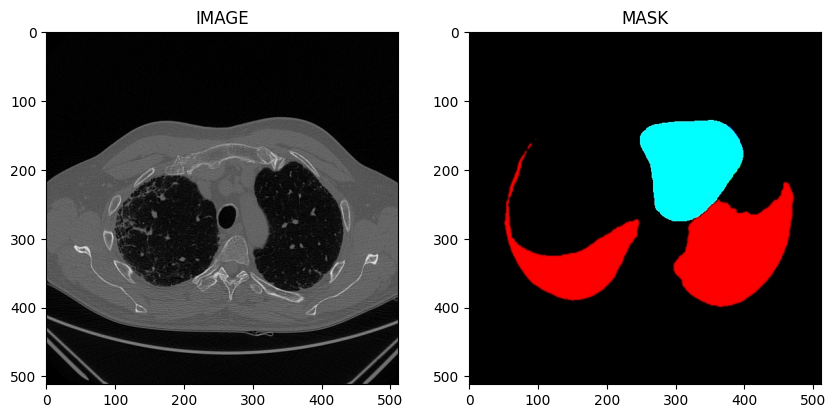

In [20]:
image_path = '/content/chestct/images/images'
mask_path = '/content/chestct/masks/masks'

id_idx = 300
id_images = os.path.join(image_path, cli_data.ImageId.values[id_idx])
id_masks = os.path.join(mask_path, cli_data.MaskId.values[id_idx])

image = cv2.imread(id_images)
mask = cv2.imread(id_masks)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(image)
plt.title('IMAGE')

plt.subplot(122)
plt.imshow(mask)
plt.title('MASK')
plt.show()

In [23]:
from google.colab.patches import cv2_imshow
# opencv로 이미지를 영상으로 보기
def show_video(cli_id):
    cli_data = data_raw[data_raw.id == cli_ids[cli_id]]

    video = np.zeros((512, 2*512+100, 3), dtype=np.uint8)
    for i in range(len(cli_data.ImageId)):

        id_images = os.path.join(image_path, cli_data.ImageId.values[i])
        id_masks = os.path.join(mask_path, cli_data.MaskId.values[i])
        image = cv2.imread(id_images)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(id_masks)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        video[:, :512, :] = image
        video[:, 512+50:512*2+50, :] = mask

        # 코렙에서 : from google.colab.patches import cv2_imshow -> cv2_imshow(video)
        cv2_imshow(video)
        # cv2.imshow('video', video)
        display.clear_output(wait=True)
        if cv2.waitKey == 27:
            cv2.destroyAllWindows()
            break
    cv2.destroyAllWindows()

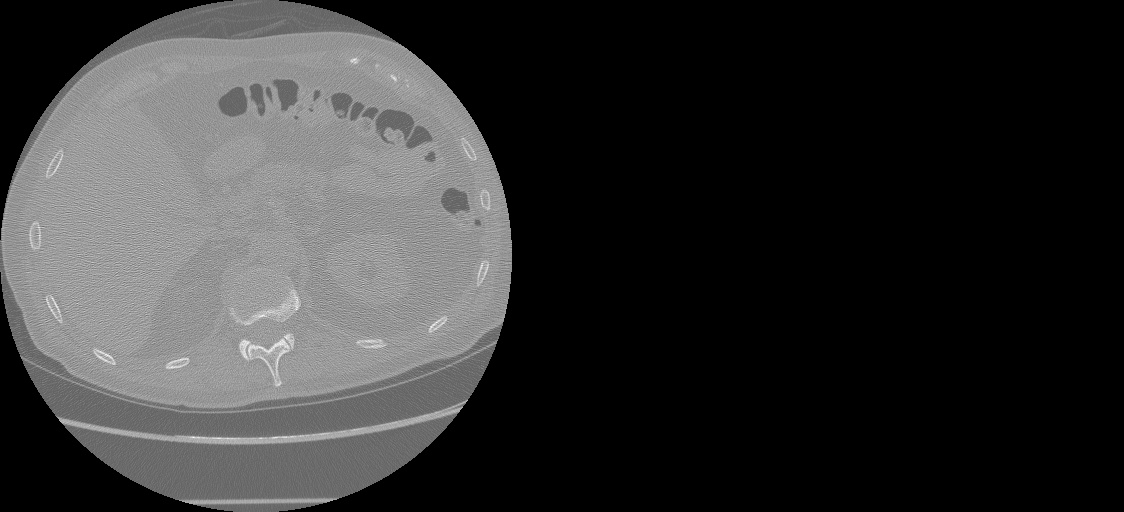

In [24]:
cli_show_id = 0
show_video(cli_show_id)

In [25]:
def get_cli_data(data_raw, cli_id):
    cli_ids = data_raw.id.unique()
    cli_data = data_raw[data_raw.id == cli_ids[cli_id]]
    image_file = cli_data.ImageId.values
    mask_file = cli_data.MaskId.values
    id_file = cli_data.id.values[0]

    return id_file, image_file, mask_file

In [26]:
cli_id = 100
id, images, masks = get_cli_data(data_raw, cli_id)
print('client Id :', id)
for img, mask in zip(images, masks):
    print(img, '\t|', mask)

client Id : ID00383637202300493233675
ID00383637202300493233675_0.jpg 	| ID00383637202300493233675_mask_0.jpg
ID00383637202300493233675_1.jpg 	| ID00383637202300493233675_mask_1.jpg
ID00383637202300493233675_2.jpg 	| ID00383637202300493233675_mask_2.jpg
ID00383637202300493233675_3.jpg 	| ID00383637202300493233675_mask_3.jpg
ID00383637202300493233675_4.jpg 	| ID00383637202300493233675_mask_4.jpg
ID00383637202300493233675_5.jpg 	| ID00383637202300493233675_mask_5.jpg
ID00383637202300493233675_6.jpg 	| ID00383637202300493233675_mask_6.jpg
ID00383637202300493233675_7.jpg 	| ID00383637202300493233675_mask_7.jpg
ID00383637202300493233675_8.jpg 	| ID00383637202300493233675_mask_8.jpg
ID00383637202300493233675_9.jpg 	| ID00383637202300493233675_mask_9.jpg
ID00383637202300493233675_10.jpg 	| ID00383637202300493233675_mask_10.jpg
ID00383637202300493233675_11.jpg 	| ID00383637202300493233675_mask_11.jpg
ID00383637202300493233675_12.jpg 	| ID00383637202300493233675_mask_12.jpg
ID003836372023004932

### 데이터셋 구축
- 이미지와 마스크 파일이 하나로 묶여 있어, train, val, test 세트로 분리를 필요

In [27]:
!mkdir data

In [28]:
%cd data

/content/data


- 디렉토리 만들기

In [29]:
!mkdir 'train' 'val' 'test'

In [30]:
!mkdir 'train/images' 'train/masks' 'val/images' 'val/masks' 'test/images' 'test/masks'

- 'id'를 기준으로 분리- train, val, test 비율: 0.8, 0.1, 0.1
- 'id'는 총 112개

In [31]:
len(cli_ids)

112

In [32]:
split_ratio = [0.8, 0.1, 0.1]
train_len = int(len(cli_ids) * split_ratio[0])
val_len = int(len(cli_ids) * split_ratio[1])
test_len = len(cli_ids) - train_len - val_len

print('{}, {}, {}'.format(train_len, val_len, test_len))

train_ids = []
val_ids = []
test_ids = []

for i in range(len(cli_ids)):
    if 0 <= i < train_len:
        train_ids.append(cli_ids[i])
    elif train_len <= i < train_len + val_len:
        val_ids.append(cli_ids[i])
    elif train_len + val_len <= i:
        test_ids.append(cli_ids[i])

print('{}, {}, {}'.format(len(train_ids), len(val_ids), len(test_ids)))

89, 11, 12
89, 11, 12


- 각각 이미지에서 나눈 'id'를 기준으로 각 디렉토리에 file 복사하기

In [273]:
data_dir = '/content/data'

In [33]:
# train/image
to_file_path = '/content/data/train/images/'
from_file_path = '/content/chestct/images/images/'

for file_name in os.listdir('/content/chestct/images/images'):
    for id in train_ids:
        if file_name.startswith(id):
            shutil.copyfile(from_file_path + file_name, to_file_path + file_name)

In [34]:
#train/mask
to_file_path = '/content/data/train/masks/'
from_file_path = '/content/chestct/masks/masks/'

for file_name in os.listdir('/content/chestct/masks/masks'):
    for id in train_ids:
        if file_name.startswith(id):
            shutil.copyfile(from_file_path + file_name, to_file_path + file_name)

In [35]:
# val/image
to_file_path = '/content/data/val/images/'
from_file_path = '/content/chestct/images/images/'

for file_name in os.listdir('/content/chestct/images/images'):
    for id in val_ids:
        if file_name.startswith(id):
            shutil.copyfile(from_file_path + file_name, to_file_path + file_name)

In [36]:
#val/mask
to_file_path = '/content/data/val/masks/'
from_file_path = '/content/chestct/masks/masks/'

for file_name in os.listdir('/content/chestct/masks/masks'):
    for id in val_ids:
        if file_name.startswith(id):
            shutil.copyfile(from_file_path + file_name, to_file_path + file_name)

In [37]:
# test/image
to_file_path = '/content/data/test/images/'
from_file_path = '/content/chestct/images/images/'

for file_name in os.listdir('/content/chestct/images/images'):
    for id in test_ids:
        if file_name.startswith(id):
            shutil.copyfile(from_file_path + file_name, to_file_path + file_name)

In [38]:
#test/mask
to_file_path = '/content/data/test/masks/'
from_file_path = '/content/chestct/masks/masks/'

for file_name in os.listdir('/content/chestct/masks/masks'):
    for id in test_ids:
        if file_name.startswith(id):
            shutil.copyfile(from_file_path + file_name, to_file_path + file_name)

- 잘 나누었는지 확인

In [39]:
# 세트로 잘 복사되었는지 확인
print('train image:',len(os.listdir('/content/data/train/images')), '\ttrain masks: ',len(os.listdir('/content/data/train/masks')))
print('valid image:',len(os.listdir('/content/data/val/images')), '\tvalid masks: ',len(os.listdir('/content/data/val/masks')))
print('test  image:',len(os.listdir('/content/data/test/images')), '\ttest  masks: ',len(os.listdir('/content/data/test/masks')))

train image: 12964 	train masks:  12964
valid image: 1914 	valid masks:  1914
test  image: 1830 	test  masks:  1830


In [40]:
aa = [img.split('_')[0] for img in os.listdir('/content/data/test/images')]
bb = [img.split('_')[0] for img in os.listdir('/content/data/test/masks')]

In [41]:
aa = sorted(aa)
bb = sorted(bb)
for a, b in zip(aa, bb):
    if a != b:
        print('ㅜ,ㅜ')
        break
else:
    print('Good')

Good


In [42]:
cnt = 0
for i in test_ids:
    if i in aa and i in bb:
        cnt += 1
print('원본 길이:', len(test_ids), '\t복사본 길이 :', cnt)

if cnt == len(test_ids):
    print('Good')
else:
    print('Error')

원본 길이: 12 	복사본 길이 : 12
Good


In [107]:
data_dir = '/content/data'
train_dir = '/content/data/train'
val_dir = '/content/data/val'
test_dir = '/content/data/test'

In [269]:
class MyDataset():
    def __init__(self, data_dir, phase, transform):
        self.phase = phase
        self.image_dir = os.path.join(data_dir, phase, 'images')
        self.mask_dir = os.path.join(data_dir, phase, 'masks')
        self.image_files = [file_name for file_name in os.listdir(self.image_dir)]
        self.mask_files = [file_name for file_name in os.listdir(self.mask_dir)]
        assert len(self.image_files) == len(self.mask_files)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        imgae = cv2.imread(os.path.join(self.image_dir, self.image_files[index]))
        mask = cv2.imread(os.path.join(self.mask_dir, self.mask_files[index]))

        # unet image size : 224*224
        image = cv2.resize(imgae.astype('float32'), dsize=(224, 224), interpolation=cv2.INTER_LINEAR) # 보간법 적용(interpolation)
        mask = cv2.resize(mask.astype('float32'), dsize=(224, 224), interpolation=cv2.INTER_NEAREST)
        mask[mask < 240] = 0
        mask[mask >= 240] = 255
        mask = mask / 255.

        # background 생성
        mask_h, mask_w, mask_c = mask.shape
        background = np.ones(shape=(mask_h, mask_w))
        background[mask[..., 0] != 0] = 0
        background[mask[..., 1] != 1] = 0
        background[mask[..., 2] != 2] = 0
        mask = np.concatenate([np.expand_dims(background, axis=-1), mask], axis=-1)
        mask = np.argmax(mask, axis=-1, keepdims=False)


        if self.transform:
            image = self.transform(image)

        label = torch.from_numpy(mask).long()# label -> torch.int

        return image, label

In [276]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [271]:
trainset = MyDataset(data_dir, "train", transform)
valset = MyDataset(data_dir, "val", transform)

dataloaders = {}
dataloaders['train'] = DataLoader(trainset, batch_size=4, shuffle=True)
dataloaders['val'] = DataLoader(valset, batch_size=1, shuffle=False)

In [282]:
for phase in ['train', 'val']:
    for idx, data in enumerate(dataloaders[phase]):
        image = data[0]
        label = data[1]
        print('phase :', image.shape, label.shape)
        break

phase : torch.Size([4, 3, 224, 224]) torch.Size([4, 224, 224])
phase : torch.Size([1, 3, 224, 224]) torch.Size([1, 224, 224])


## U-NET 아키텍쳐 구현

In [335]:
def conv_layer(in_channels, out_channels):
    layers = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True),

                            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True)
    )
    return layers

In [338]:
class Encoder(nn.Module):
    def __init__(self,):
        super().__init__()

        self.conv_block1 = conv_layer(in_channels=3, out_channels=64)
        self.conv_block2 = conv_layer(in_channels=64, out_channels=128)
        self.conv_block3 = conv_layer(in_channels=128, out_channels=256)
        self.conv_block4 = conv_layer(in_channels=256, out_channels=512)
        self.conv_block5 = conv_layer(in_channels=512, out_channels=1024)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        skip_con = []

        out = self.conv_block1(x)
        skip_con.append(out)
        out = self.pool(out)

        out = self.conv_block2(out)
        skip_con.append(out)
        out = self.pool(out)

        out = self.conv_block3(out)
        skip_con.append(out)
        out = self.pool(out)

        out = self.conv_block4(out)
        skip_con.append(out)
        out = self.pool(out)

        out = self.conv_block5(out)

        return out, skip_con

In [348]:
def upconv_layer(in_channels, out_channels):
    layers = nn.Sequential(
                            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True)
    )
    return layers

In [349]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.upconv_layer1 = upconv_layer(in_channels=1024, out_channels=512)
        self.conv_block1 = conv_layer(in_channels=512+512, out_channels=512) # skip +

        self.upconv_layer2 = upconv_layer(in_channels=512, out_channels=256)
        self.conv_block2 = conv_layer(in_channels=256+256, out_channels=256) # skip +

        self.upconv_layer3 = upconv_layer(in_channels=256, out_channels=128)
        self.conv_block3 = conv_layer(in_channels=128+128, out_channels=128) # skip +

        self.upconv_layer4 = upconv_layer(in_channels=128, out_channels=64)
        self.conv_block4 = conv_layer(in_channels=64+64, out_channels=64) # skip +

    def forward(self, x, skip_con):
        out = self.upconv_layer1(x)
        out = torch.cat([out, skip_con[-1]], dim=1)
        out = self.conv_block1(out)

        out = self.upconv_layer2(out)
        out = torch.cat([out, skip_con[-2]], dim=1)
        out = self.conv_block2(out)

        out = self.upconv_layer3(out)
        out = torch.cat([out, skip_con[-3]], dim=1)
        out = self.conv_block3(out)

        out = self.upconv_layer4(out)
        out = torch.cat([out, skip_con[-4]], dim=1)
        out = self.conv_block4(out)

        return out

In [352]:
encoder = Encoder()
decoder = Decoder()

x = torch.randn(1, 3, 224, 224)
out, ftrs = encoder(x)
out = decoder(out, ftrs)

print(out.shape)

torch.Size([1, 64, 224, 224])


In [353]:
class UNET(nn.Module):
    def __init__(self, num_class):
        super(UNET, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()
        self.head = nn.Conv2d(64, num_class, kernel_size=1, padding=0)

    def forward(self, x):
        out, skip_con = self.encoder(x)
        out = self.decoder(out, skip_con)
        out = self.head(out)

        return out

In [354]:
model = UNET(num_class=4)
x = torch.randn(1, 3, 224, 224)
out = model(x)

print('input shape: ', x.shape)
print('output shape: ', out.shape)

input shape:  torch.Size([1, 3, 224, 224])
output shape:  torch.Size([1, 4, 224, 224])
